참고 : https://velog.io/@krec7748/Pytorch-Yolo-v3-%EA%B5%AC%ED%98%84

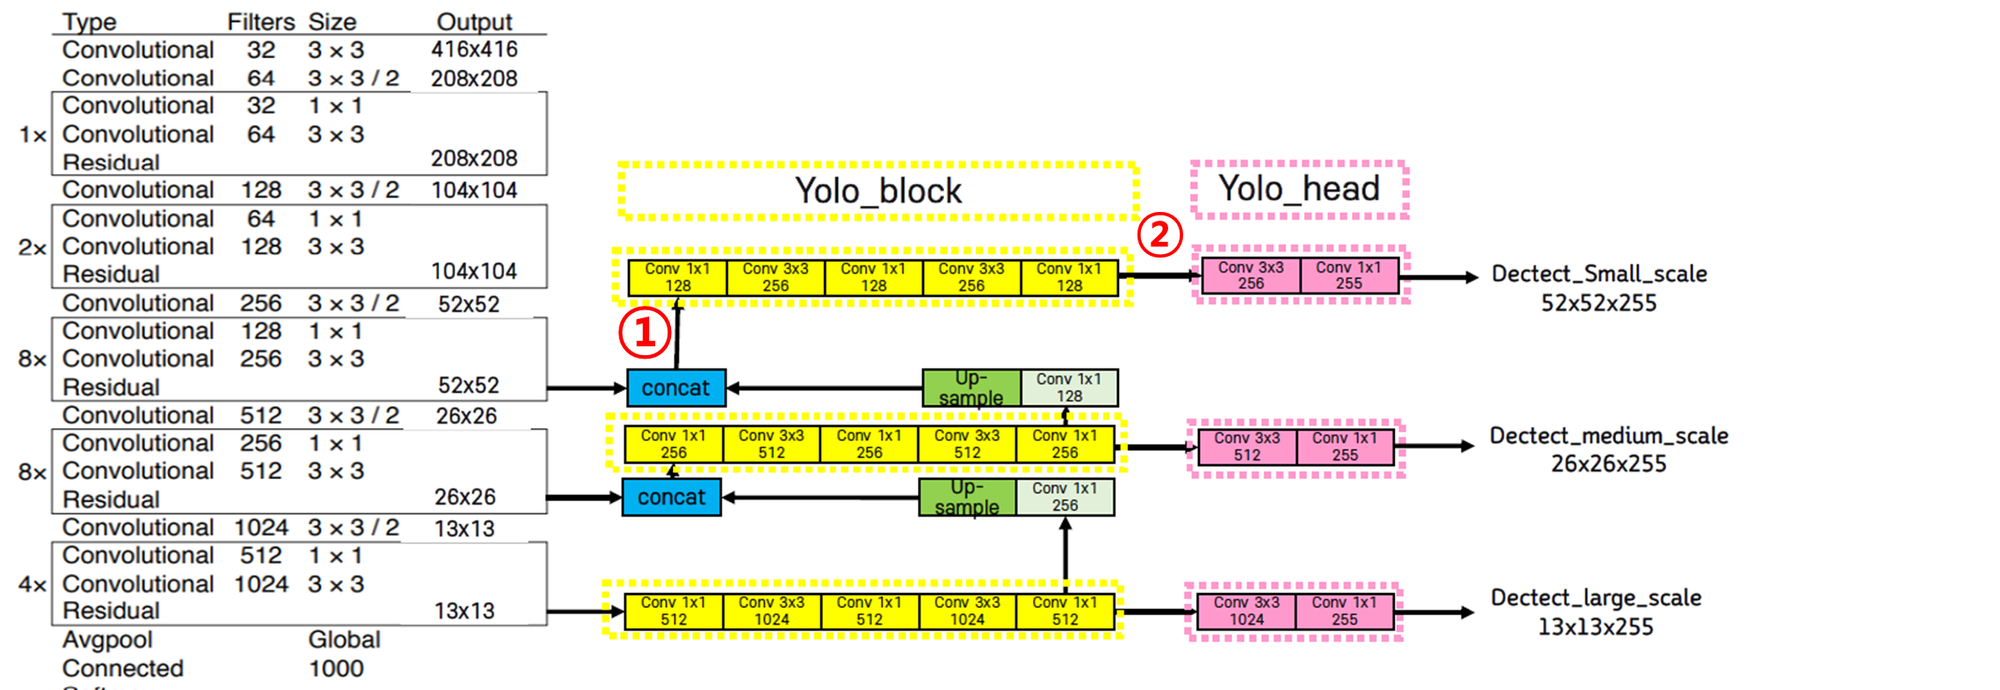

In [ ]:
import torch
from torch import nn
from torchinfo import summary
# Build Model

class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=(kernel_size - 1) // 2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.residual = nn.Sequential(
            BasicConv(channels, channels // 2, 1),
            BasicConv(channels // 2, channels, 3),
        )

    def forward(self, x):
        return self.residual(x) + x

In [ ]:
class DarkNet53(nn.Module):
    def __init__(self):
        super().__init__()

        self.first_conv_block = BasicConv(3, 32, 3)

        self.residual_block_01 = nn.Sequential(
            BasicConv(32, 64, 3, stride=2),
            ResidualBlock(64),
        )
        self.residual_block_02 = nn.Sequential(
            BasicConv(64, 128, 3, stride=2),
            nn.Sequential(*[ResidualBlock(128) for _ in range(2)]),
        )
        self.residual_block_03 = nn.Sequential(
            BasicConv(128, 256, 3, stride=2),
            nn.Sequential(*[ResidualBlock(256) for _ in range(8)]),
        )
        self.residual_block_04 = nn.Sequential(
            BasicConv(256, 512, 3, stride=2),
            nn.Sequential(*[ResidualBlock(512) for _ in range(8)]),
        )
        self.residual_block_05 = nn.Sequential(
            BasicConv(512, 1024, 3, stride=2),
            nn.Sequential(*[ResidualBlock(1024) for _ in range(4)]),
        )

    def forward(self, x):
        x = self.first_conv_block(x)
        x = self.residual_block_01(x)
        x = self.residual_block_02(x)
        route01 = self.residual_block_03(x)
        route02 = self.residual_block_04(route01)
        route03 = self.residual_block_05(route02)
        return route01, route02, route03

In [ ]:
class YoloBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.yoloblock_conv = nn.Sequential(
            BasicConv(in_channels, out_channels, 1),
            BasicConv(out_channels, out_channels * 2, 3),
            BasicConv(out_channels * 2, out_channels, 1),
            BasicConv(out_channels, out_channels * 2, 3),
            BasicConv(out_channels * 2, out_channels, 1),
        )

    def forward(self, x):
        yoloblock_output = self.yoloblock_conv(x)
        return yoloblock_output

In [ ]:
class YoloHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.yolohead = nn.Sequential(
            BasicConv(in_channels, in_channel*2, 3),
            nn.Conv2d(in_channels*2, (num_classes + 5) * 3, 1)
        )

    def forward(self, x):
        output = self.yolohead(x)
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3))
        output = output.permute(0, 1, 3, 4, 2)
        return output

In [ ]:
class Upsampling(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            BasicConv(in_channels, in_channels//2, 1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        return self.upsample(x)

In [ ]:
class Yolov3(nn.Module):
    def __init__(self, num_classes = 80):
        super().__init__()

        self.num_classes = num_classes

        self.darknet53 = DarkNet53()

        self.yoloblock_01 = YoloBlock(1024, 512)
        self.yolohead_01 = YoloHead(512, num_classes)
        self.upsample_01 = Upsampling(512)

        self.yoloblock_02 = YoloBlock(512 + 256, 256)
        self.yolohead_02 = YoloHead(256, num_classes)
        self.upsample_02 = Upsampling(256)

        self.yoloblock_03 = YoloBlock(256 + 128, 128)
        self.yolohead_03 = YoloHead(128, num_classes)
    
    def forward(self, x):

        self.route_01, self.route_02, self.route_03 = self.darknet53(x)

        output_01 = self.yoloblock_01(self.route_03) # 512가 됨.
        output_01 = self.yolohead_01(output_01)
        x = self.upsample_01(output_01)

        output_02 = self.yoloblock_02(torch.cat([x, self.route_02], dim = 1))
        output_02 = self.yolohead_02(output_02)
        x = self.upsample_02(output_02)

        output_03 = self.yoloblock_03(torch.cat([x, self.route_01], dim = 1))
        output_03 = self.yolohead_03(output_03)

        return output_01, output_02, output_03

In [ ]:
x = torch.randn((1, 3, 416, 416))
model = Yolov3(num_classes = 20)
out = model(x)
print(out[0].shape) # torch.Size([1, 3, 13, 13, 25])
print(out[1].shape) # torch.Size([1, 3, 26, 26, 25])
print(out[2].shape) # torch.Size([1, 3, 52, 52, 25])

In [ ]:
summary(model, input_size = (2, 3, 416, 416), device = "cpu")

In [ ]:
# Anchors
ANCHORS = [ 
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
]

GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 
print(scaled_anchors, scaled_anchors.shape)
"""
tensor([[[ 3.6400,  2.8600],
         [ 4.9400,  6.2400],
         [11.7000, 10.1400]],

        [[ 1.8200,  3.9000],
         [ 3.9000,  2.8600],
         [ 3.6400,  7.5400]],

        [[ 1.0400,  1.5600],
         [ 2.0800,  3.6400],
         [ 4.1600,  3.1200]]]) torch.Size([3, 3, 2])
"""

In [ ]:
# Loss function
# 출처: https://www.geeksforgeeks.org/yolov3-from-scratch-using-pytorch/

def iou(box1, box2, is_pred = True):
    if is_pred:
        # IoU score for prediction and label
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format

        box1_x_center = box1[..., 0:1]; box2_x_center = box2[..., 0:1]
        box1_y_center = box1[..., 1:2]; box2_y_center = box2[..., 1:2]
        box1_width = box1[..., 2:3]; box2_width = box2[..., 2:3]
        box1_height = box1[..., 3:4]; box2_height = box2[..., 3:4]

        # Box coordinates for prediction
        box1_xmin = box1_x_center - box1_width / 2
        box1_ymin = box1_y_center - box1_height / 2
        box1_xmax = box1_x_center + box1_width / 2
        box1_ymax = box1_y_center + box1_height / 2

        # Box coordinates for ground truth
        box2_xmin = box2_x_center - box2_width / 2
        box2_ymin = box2_y_center - box2_height / 2
        box2_xmax = box2_x_center + box2_width / 2
        box2_ymax = box2_y_center + box2_height / 2

        # Get the coordinates of the intersection rectangle
        its_xmin = torch.max(box1_xmin, box2_xmin)
        its_ymin = torch.max(box1_ymin, box2_ymin)
        its_xmax = torch.min(box1_xmax, box2_xmax)
        its_ymax = torch.min(box1_ymax, box2_ymax)

        # Calculate Intersection area (min: 0)
        intersection_area = (its_xmax - its_xmin).clamp(min = 0) * (its_ymax - its_ymin).clamp(min = 0)

        # Calculate the union area
        box1_area = abs(box1_width * box1_height)
        box2_area = abs(box2_width * box2_height)
        union = box1_area + box2_area - intersection_area

        # Calculate the IoU score
        epsilon = 1e-6
        iou_score = intersection_area / (union + epsilon)

        return iou_score
    
    else:
        # IoU score based on width and height of bounding boxes (If the two boxes have the same center coordinates)

        box1_width = box1[..., 0]; box2_width = box2[..., 0]
        box1_height = box1[..., 0]; box2_height = box2[..., 1]

        # Calculate interaction area
        intersection_area = torch.min(box1_width, box2_width) * torch.min(box2_width, box2_height)

        # Calculate union area
        box1_area = box1_width * box1_height
        box2_area = box2_width * box2_height
        union_area = box1_area + box2_area - intersection_area

        # Calculate the IoU score
        iou_score = intersection_area / union_area

        # Return IoU score
        return iou_score
    
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions = True):
    batch_size = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]

    # If the input is predictions then we will pass the x and y coordinate
    # through sigmoid function and width and height to exponent function and
    # calculate the score and best class.
    if is_predictions:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:] * anchors)
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim = 1).unsqueeze(-1)
    
    # Else we will just calculate scores and best class.
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]
    
    # Calculate cell indices
    cell_indices = (
        torch.arange(s)
        .repeat(predictions.shape[0], 3, s, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )

    # Calculate x, y, width and height with proper scaling
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / s * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))

    width_height = 1 / s * box_predictions[..., 2:4]

    # Concatinating the values and reshaping them in
    # (BATCH_SIZE, num_anchors * S * S, 6) shape
    converted_bboxes = torch.cat(
        (best_class, scores, x, y, width_height), dim = -1
    ).reshape(batch_size, num_anchors * s * s, 6)

    # Returning the reshaped and converted bounding box list
    return converted_bboxes.tolist()

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, pred, target, anchors):

        # Identifying which cells in target have objects and which have no objects
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss
        no_object_loss = self.bce(
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]),
        )

        # Reshaping anchors to match predictions
        anchors = anchors.reshape(1, 3, 1, 1, 2)

        # Box predict confidence
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]),
                               torch.exp(pred[..., 3:5]) * anchors], dim = -1)
        
        # Calculating IoU for prediction and target
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()

        # Calculating Object loss
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]),
                               ious * target[..., 0:1][obj])
        
        # Predicted box coordinates
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])

        # Target box coordinates
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors)

        # Calculating box coordinates
        box_loss = self.mse(pred[..., 1:5][obj], target[..., 1:5][obj])

        # Calculating class loss
        class_loss = self.ce((pred[..., 5:][obj]), target[..., 5:][obj].long())
        
        # Total loss
        return (
            box_loss
            + object_loss
            + no_object_loss
            + class_loss
        )